In [1]:
# define a pytensor Op for our likelihood function
from pl_temp_fit import Exp_data_utils, fit_Pl_exp_EMCEE

import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import os
os.chdir('/rds/general/user/ma11115/home/pl_temp_fit/') 

experiemental_data/Y6_SWrecipe.csv


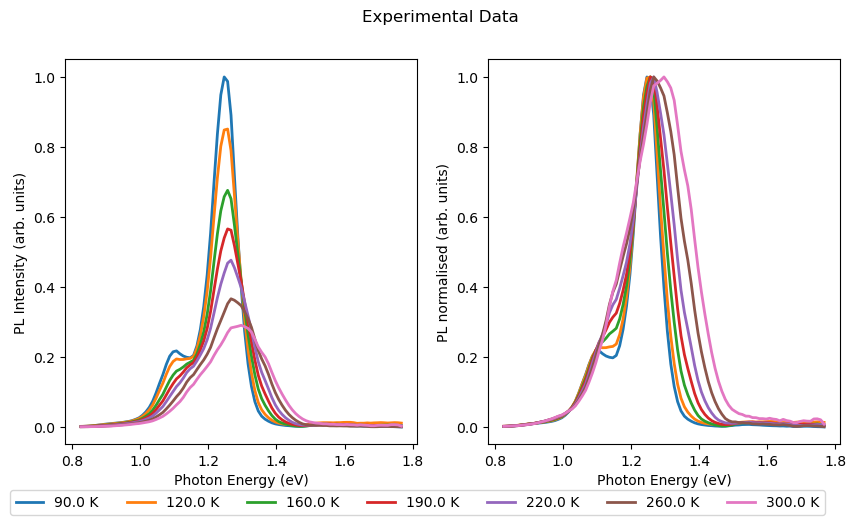

In [2]:
# import the data and plot them
import importlib
import glob
csv_files = glob.glob('experiemental_data/*.csv')
csv_name=csv_files[3]#3 for y6, 18 for ITIC,12 for L8BO
print(csv_name)
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
fig,ax = Exp_data_utils.plot_PL_data(Exp_data, temperature_list, hws,title="Experimental Data")

In [45]:
#initialise parameters for the model
number_free_parameters , sigma, Temp_std_err, hws_std_err, relative_intensity_std_error = 5, 0.005, 10, 0.005, 0.05
num_samples = 1000
num_tune = 1000

model_config = {
            "number_free_parameters": number_free_parameters,
            "sigma": sigma,
            "Temp_std_err": Temp_std_err,
            "hws_std_err": hws_std_err,
            "relative_intensity_std_error": relative_intensity_std_error,
        }
X = {'temperature_list':temperature_list, 'hws':hws}
date=datetime.datetime.now().strftime("%Y_%m_%d")
# generate the data
save_folder = (
    f"fit_experimental_emcee/{date}/{csv_name.split('/')[-1]}/num_samples="
    + " sigma=" + str(sigma)
    + " temperature_list=" + str(len(temperature_list))
    + " number_free_parameters=" + str(number_free_parameters)
    + " Temp_std_err="+str(Temp_std_err)
    + " hws_std_err="+str(hws_std_err)
    + " relative_intensity_std_error="+str(relative_intensity_std_error)
)
os.makedirs(save_folder, exist_ok=True)

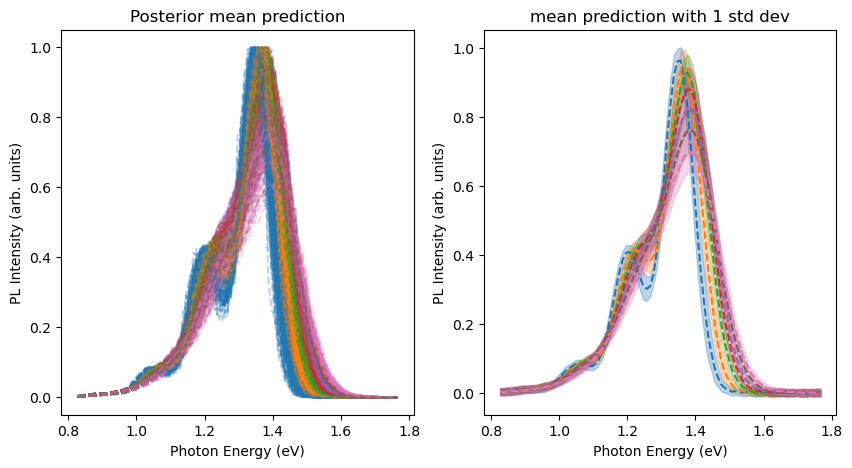

In [5]:
import importlib
importlib.reload(fit_Pl_exp_EMCEE)
#get covariance matrix for the experimental data

co_var_mat = fit_Pl_exp_EMCEE.plot_generated_data( temperature_list, hws, save_folder, model_config, savefig=True)

(<Figure size 2000x500 with 7 Axes>,
 array([<Axes: title={'center': 'temperature=90.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=120.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=160.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=190.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=220.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=260.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=300.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>],
       dtype=object))

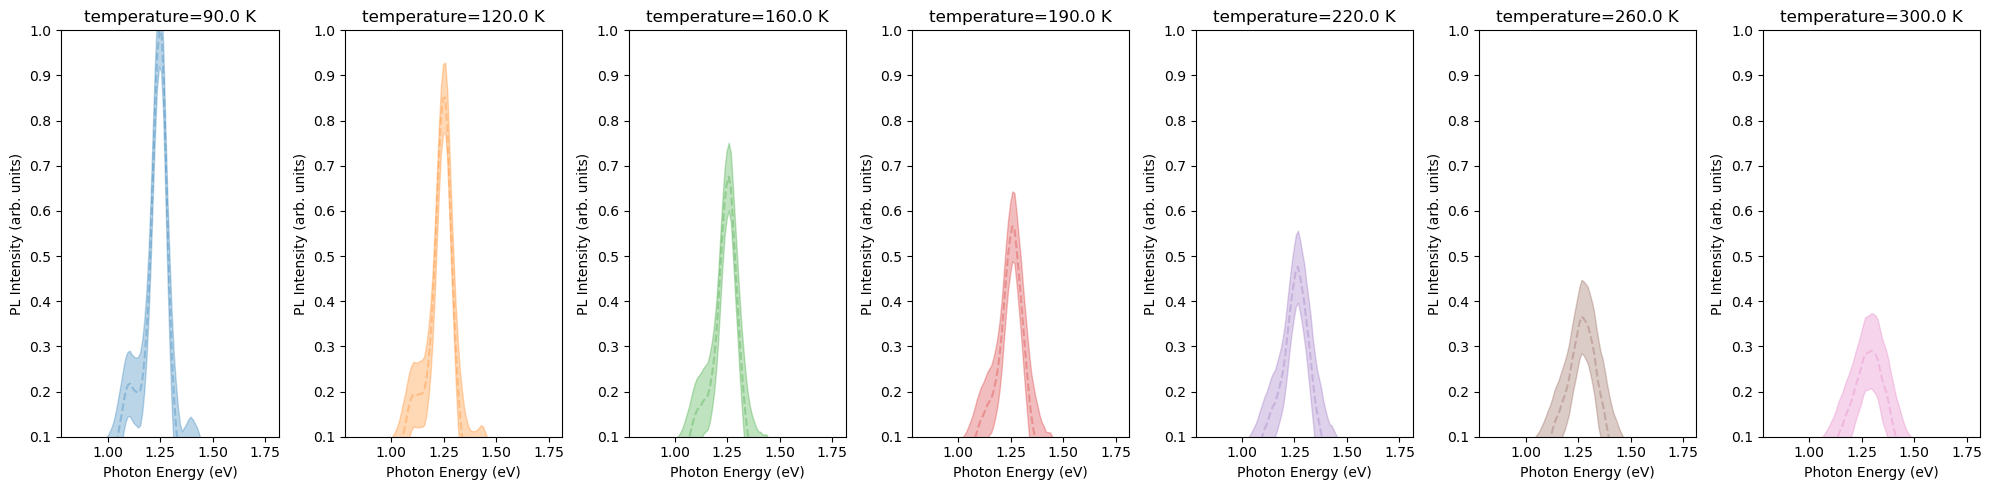

In [6]:
# add noise to the data and plot it
variance_data = co_var_mat.diagonal().reshape(hws.shape[0],-1).copy()#variance.copy()
Exp_data_utils.plot_PL_data_with_variance(Exp_data, temperature_list, hws, variance_data, save_folder)


In [7]:
import numpy as np
import importlib
from pl_temp_fit import LTPL
def pl_trial(theta, temperature_list, hws):

    E, sigma, LI, L0, H0 = theta
    data = LTPL.Data()
    data.CT = LTPL.State(
        E=1.1,
        vmhigh=2,
        vmlow=2,
        sigma=0.01,
        numbrstates=20,
        off=1,
        LI=0.1,
        L0=0.1,
        H0=0.15,
        fosc=5,
    )
    data.D.hw = np.arange(0.5, 3, 0.01)
    data.D.T = temperature_list  # np.array([300.0, 150.0, 80.0])
    data.EX = LTPL.State(
        E=E,
        vmhigh=5,
        vmlow=15,
        sigma=sigma,
        numbrstates=20,
        off=0,
        LI=LI,
        L0=L0,
        H0=H0,
        fosc=5,
    )
    LTPL.LTPLCalc(data)
    PL_results = data.D.kr_hw#.reshape(-1, 1)
    PL_results_interp = np.zeros((len(hws), len(temperature_list)))
    for i in range(len(temperature_list)):
        PL_results_interp[:, i] = np.interp(hws, data.D.hw, PL_results[:, i])

    return PL_results_interp# / max(PL_results)

def log_prior(theta):
    E, sigma_E, LI, L0, H0 = theta
    if 1 < E < 2 and 0.001 < sigma_E < 0.03 and 0.03 < LI < 0.2:
        if 0.03 < L0 < 0.2 and 0.1 < H0 < 0.2:
            return 0.0
    return -np.inf
def pl_loglike( theta, data, co_var_mat, temperature_list, hws):
    data = data/np.max(data.reshape(-1, 1))
    model_data = pl_trial(list(theta), temperature_list, hws)
    model_data = model_data/np.max(model_data.reshape(-1, 1))
    data = data.reshape(-1, 1)
    model_data = model_data.reshape(-1, 1)
    # check that the data in model_data does not contain NaNs or infs
    if np.isnan(model_data).any() or np.isinf(model_data).any():
        print("NaN in model_data")
        return -np.inf
    diff = data - model_data
    diff[np.abs(diff) < 1e-4] = 0
    loglike = -0.5 * np.dot(diff.T, np.dot(np.linalg.inv(co_var_mat), diff))
    return loglike
def log_probability(theta, data, inv_covar ,temperature_list, hws):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    log_like = pl_loglike(theta, data, inv_covar, temperature_list, hws)
    #print(theta, log_like)
    return lp + log_like

In [8]:
from scipy.optimize import minimize
nll = lambda *args: -fit_Pl_exp_EMCEE.pl_loglike(*args)
init_params = [1.37, 0.02, 0.06, 0.08, 0.16]
soln = minimize(nll, init_params, args=(Exp_data, co_var_mat,  temperature_list, hws),bounds=((1,2),(0.001,0.03),(0.03,0.2),(0.03,0.2),(0.1,0.2)),tol=1e-3)
print(soln.x)
print("Maximum likelihood estimates:")
print(f"  E = {soln.x[0]:.3f}")
print(f"  sigma = {soln.x[1]:.3f}")
print(f"  LI = {soln.x[2]:.3f}")
print(f"  L0 = {soln.x[3]:.3f}")
print(f"  H0 = {soln.x[4]:.3f}")
print("Maximum log likelihood:", soln.fun)

[1.34762865 0.01174207 0.05912519 0.08673928 0.16087058]
Maximum likelihood estimates:
  E = 1.348
  sigma = 0.012
  LI = 0.059
  L0 = 0.087
  H0 = 0.161
Maximum log likelihood: 31.420579985339298


(<Figure size 2000x500 with 7 Axes>,
 array([<Axes: title={'center': 'temperature=90.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=120.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=160.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=190.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=220.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=260.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>,
        <Axes: title={'center': 'temperature=300.0 K'}, xlabel='Photon Energy (eV)', ylabel='PL Intensity (arb. units)'>],
       dtype=object))

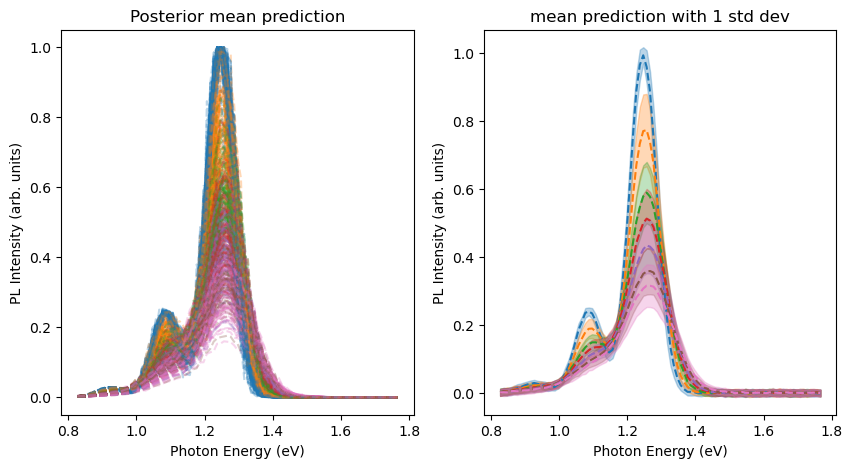

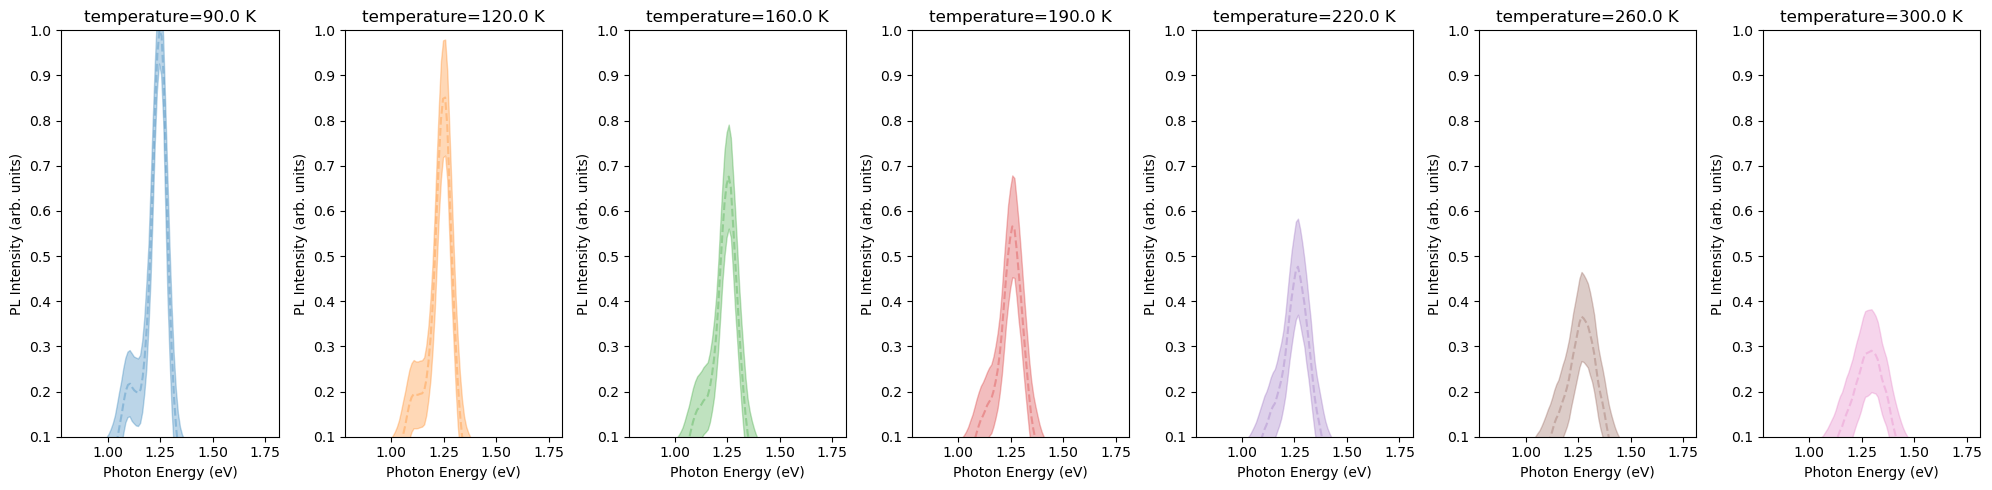

In [9]:
# add noise to the data and plot it now with the fitted parameters
co_var_mat = fit_Pl_exp_EMCEE.plot_generated_data( temperature_list, hws, save_folder, model_config, savefig=True, true_parameters=soln.x)
variance_data = co_var_mat.diagonal().reshape(hws.shape[0],-1).copy()#variance.copy()
Exp_data_utils.plot_PL_data_with_variance(Exp_data, temperature_list, hws, variance_data, save_folder)

In [46]:
import importlib
importlib.reload(fit_Pl_exp_EMCEE)

sampler = fit_Pl_exp_EMCEE.run_sampler_single(save_folder, soln, Exp_data, co_var_mat, X,nsteps =100)

Initial size: 0


  1%|          | 1/100 [00:04<08:06,  4.92s/it]Traceback (most recent call last):
  File "/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/fit_Pl_exp_EMCEE.py", line 244, in log_probability
    log_like = pl_loglike(theta, data, inv_covar, X['temperature_list'], X['hws'])
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/fit_Pl_exp_EMCEE.py", line 226, in pl_loglike
    model_data = pl_trial(list(theta), temperature_list, hws)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/fit_Pl_exp_EMCEE.py", line 207, in pl_trial
    LTPL.LTPLCalc(data)
  File "/rds/general/user/ma1111

emcee: Exception while calling your likelihood function:
  params: [1.36002909 0.01055242 0.054654   0.10347303 0.16906072]
  args: (array([[1.45924439e-03, 1.75632660e-03, 1.14114536e-03, 1.08060779e-03,
        9.23279448e-04, 5.91684598e-04, 5.12940272e-04],
       [1.93603780e-03, 2.04534092e-03, 1.41623389e-03, 1.22383690e-03,
        9.67369374e-04, 7.20921661e-04, 6.58896907e-04],
       [2.51314218e-03, 2.58724944e-03, 1.82093727e-03, 1.57222060e-03,
        1.24817642e-03, 8.71851505e-04, 7.47850194e-04],
       [3.24571560e-03, 3.23713457e-03, 2.27641163e-03, 1.95881738e-03,
        1.51886353e-03, 1.12288024e-03, 9.42008829e-04],
       [4.18846159e-03, 4.04028234e-03, 2.87945158e-03, 2.38536390e-03,
        1.78468621e-03, 1.31292155e-03, 1.08293259e-03],
       [5.40106897e-03, 5.06545685e-03, 3.67659407e-03, 3.01405164e-03,
        2.35299261e-03, 1.66384605e-03, 1.37200746e-03],
       [6.62254462e-03, 6.07069628e-03, 4.38378712e-03, 3.71918761e-03,
        2.88164005e-0

KeyboardInterrupt: 

In [43]:
# submit to HPC
import glob
csv_files = glob.glob('experiemental_data/*.csv')
csv_name=csv_files[18]#3 for y6, 18 for ITIC,12 for L8BO
sh_name = f"Run_EMCEE_ITIC_12.sh"
script="#!/bin/bash \n"+\
    "#PBS -l walltime=07:59:01 \n"+\
    "#PBS -l select=1:ncpus=32:mem=50gb:avx=true \n"+\
    " \n"+\
    "cd /rds/general/user/ma11115/home/pl_temp_fit/ \n"+\
    "module load anaconda3/personal \n"+ \
    "source activate pymc_env     \n"+\
    f"python src/pl_temp_fit/fit_Pl_exp_EMCEE.py --test_number 2 --data_file {csv_name} \n"#${'PBS_ARRAY_INDEX'}#f"#PBS -J 1-{16} \n"+\
#print(script) 
with open(f'HPC_bash_script/{sh_name}', 'wb') as f:
    f.write( bytes(script, 'utf-8'))  

!qsub  -e ./cache -o ./cache HPC_bash_script/Run_EMCEE_ITIC_12.sh #submit to HPC

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
sh: which: line 1: syntax error: unexpected end of file


In [54]:
saver_folder

'fit_experimental_emcee/2024_01_24/Y6_SWrecipe.csv/ sigma=0.01 temperature_list=7 number_free_parameters=5 Temp_std_err=2 hws_std_err=0.05 relative_intensity_std_error=0.01'

In [58]:
# analyse results
import importlib
import glob
csv_files = glob.glob('experiemental_data/*.csv')
csv_name=csv_files[3]#3 for y6, 18 for ITIC,12 for L8BO

folder = glob.glob(f"fit_experimental_emcee/*/{csv_name.split('/')[-1]}/*")
for f in folder:
    name = f.split('/')[-1]
    if 'sampler.h5' in os.listdir(f):
        saver_folder = f
        print(f)
        break


fit_experimental_emcee/2024_01_24/Y6_SWrecipe.csv/ sigma=0.01 temperature_list=7 number_free_parameters=5 Temp_std_err=2 hws_std_err=0.05 relative_intensity_std_error=0.01


In [76]:
# reload sampler from file
filename = saver_folder + "/sampler.h5"

reader = fit_Pl_exp_EMCEE.hDFBackend_2(filename, name="multi_core")
print("Initial size: {0}".format(reader.iteration))
#new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(Exp_data, co_var_mat, temperature_list, hws),backend=new_backend)
#new_sampler.run_mcmc(new_sampler.get_chain()[0, :, :], 10, progress=True)
#print("Final size: {0}".format(new_backend.iteration))

Initial size: 4602


(147264,)


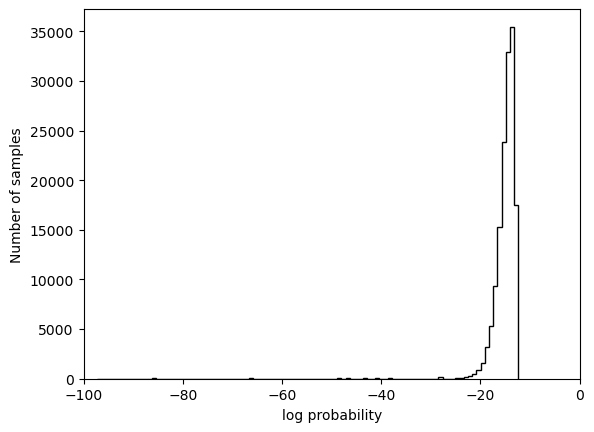

In [77]:
flat_samples = reader.get_log_prob(discard=2, thin=1, flat=True)
print(flat_samples.shape)
plt.hist(flat_samples[flat_samples>-1e2], 100, color="k", histtype="step")
plt.xlabel("log probability")
plt.ylabel("Number of samples")
plt.xlim(-100,0)
plt.show()

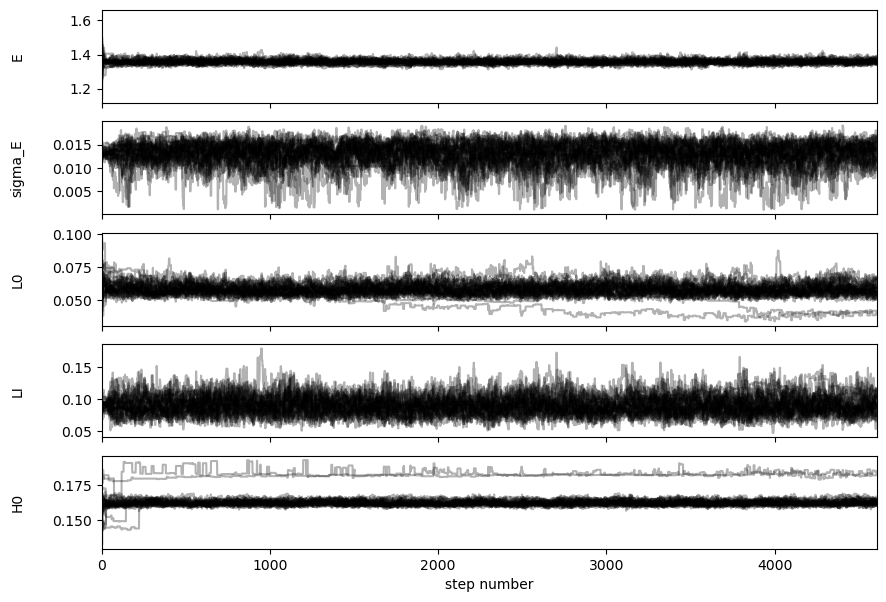

In [78]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = reader.get_chain()
labels = ["E", "sigma_E", "L0", "LI", "H0"]
ndim = len(labels)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
fig.show()

In [79]:
tau = reader.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 92;
tau: [103.12259536 104.16161377 140.41324019 111.45444822  86.52021642]

(147264,)


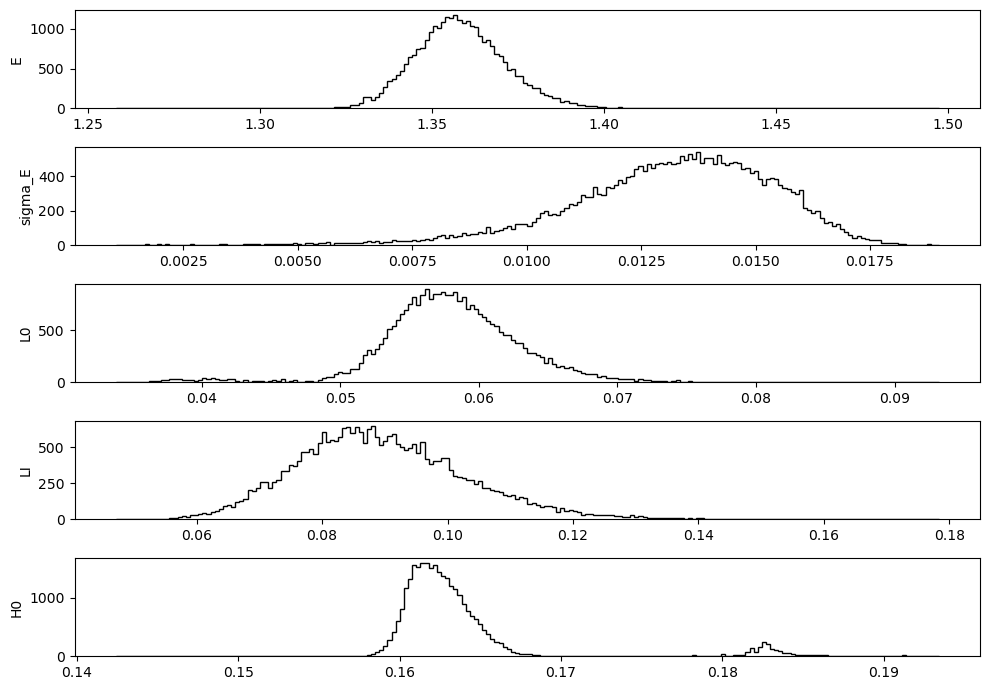

In [80]:
#flat_samples.shape
distribution = reader.get_chain(discard=1, thin=5, flat=True)
print(flat_samples.shape)
fig, axes = plt.subplots(5, figsize=(10, 7))
for i in range(ndim):
    ax = axes[i]
    ax.hist(distribution[:, i], 200, color="k", histtype="step")
    #ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)
fig.tight_layout()